# Predicting Customer Churn in Telecommunication Operators
Customer turnover refers to a decision made by the customer on the term of business relationship. Customer loyalty and customer turnover always add up to 100%. If a company has a 60% loyalty rate, then customer loss taxes are 40%. According to the 80/20 customer profitability rule, 20% of customers are generating 80% of revenue. Therefore, it is very important to predict the users who are likely to abandon the business relationship and the factors that affect how the customer's decisions.<br><br>
In this project, I predicted Customer Churn at a Telecommunications Operator using pyspark and frameworks (Pandas, Numpy, scipy and Scikit-Learn).

In [21]:
# Importing libraries and frameworks
from pyspark.sql.functions import col, sum
from pyspark.sql import Row
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

from scipy.stats import skew, kurtosis

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import operator as op
import folium
from IPython.display import display
from IPython.display import Image

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [11]:
# Creating Spark Session
spSession = SparkSession.builder.master("local").appName("local-SparkMLLib").getOrCreate()

## Importing dataset

In [2]:
df_train = spark.read.csv("data/projeto4_telecom_treino.csv", header=True)
df_test = spark.read.csv("data/projeto4_telecom_teste.csv", header=True)

## Exploratory Analysis

In [10]:
# Checking train data
display(df_train.head(5))

(3333, 21)


[Row(_c0='1', state='KS', account_length='128', area_code='area_code_415', international_plan='no', voice_mail_plan='yes', number_vmail_messages='25', total_day_minutes='265.1', total_day_calls='110', total_day_charge='45.07', total_eve_minutes='197.4', total_eve_calls='99', total_eve_charge='16.78', total_night_minutes='244.7', total_night_calls='91', total_night_charge='11.01', total_intl_minutes='10', total_intl_calls='3', total_intl_charge='2.7', number_customer_service_calls='1', churn='no'),
 Row(_c0='2', state='OH', account_length='107', area_code='area_code_415', international_plan='no', voice_mail_plan='yes', number_vmail_messages='26', total_day_minutes='161.6', total_day_calls='123', total_day_charge='27.47', total_eve_minutes='195.5', total_eve_calls='103', total_eve_charge='16.62', total_night_minutes='254.4', total_night_calls='103', total_night_charge='11.45', total_intl_minutes='13.7', total_intl_calls='3', total_intl_charge='3.7', number_customer_service_calls='1', chu

In [11]:
# Ckecking size of datasets
print((df_train.count(), len(df_train.columns)))
print((df_test.count(), len(df_train.columns)))

(3333, 21)
(1667, 21)


In [24]:
# Checking for missing values on train and test datasets
df_train.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_train.columns)).show()
df_test.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_train.columns)).show()

+---+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-----+
|_c0|state|account_length|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churn|
+---+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+--------

In [25]:
df_train.columns

['_c0',
 'state',
 'account_length',
 'area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'churn']

In [3]:
# Compute numerical data summary statistics
df_train_num = df_train.select(['account_length', 'number_vmail_messages', 'total_day_minutes',
                        'total_day_calls', 'total_day_charge', 'total_eve_minutes', 
                        'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 
                        'total_night_calls', 'total_night_charge', 'total_intl_minutes', 
                        'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls'])

# converting columns to numeric and calculating median
for col_name in df_train_num.columns:
    df_train_num = df_train_num.withColumn(col_name, df_train_num[col_name].cast('float'))

summary_df = df_train_num.describe().toPandas()

s = ['account_length', 'number_vmail_messages', 'total_day_minutes',
                        'total_day_calls', 'total_day_charge', 'total_eve_minutes', 
                        'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 
                        'total_night_calls', 'total_night_charge', 'total_intl_minutes', 
                        'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']


df = pd.DataFrame([pd.to_numeric(summary_df[col]) for col in s]).T.round(2)
idx = 0
df.insert(loc=idx, column='summary', value=summary_df.summary.values)

In [97]:
# Calculating percentiles 
median = [df_train_num.approxQuantile(col, [0.5], 0.0)[0] for col in df_train_num.columns]
first_quartile = [df_train_num.approxQuantile(col, [0.25], 0.0)[0] for col in df_train_num.columns]
third_quartile = [df_train_num.approxQuantile(col, [0.75], 0.0)[0] for col in df_train_num.columns]

In [100]:
# Getting mean absolute deviation
def mad(col, axis=None):
    data = [int(row[col]) for row in df_train_num.select(col).collect()]
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

mad_lst = [mad(col) for col in df_train_num.columns]

# Getting skewness
skew_list = [skew([int(row[col]) for row in df_train_num.select(col).collect()])
            for col in df_train_num.columns]

# Getting kurtosis
kurt = [kurtosis([int(row[col]) for row in df_train_num.select(col).collect()])
            for col in df_train_num.columns]

In [102]:
# summary_df.append(lst)
df.loc['5'] = ['25%'] + first_quartile
df.loc['6'] = ['50%'] + median
df.loc['7'] = ['75%'] + third_quartile
df.loc['8'] = ['mad'] + mad_lst
df.loc['9'] = ['skew'] + skew_list
df.loc['10'] = ['kurt'] + kurt

In [106]:
display(df.set_index('summary').round(2))

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
summary,,,,,,,,,,,,,,,
count,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00
mean,101.06,8.10,179.78,100.44,30.56,200.98,100.11,17.08,200.87,100.11,9.04,10.24,4.48,2.76,1.56
stddev,39.82,13.69,54.47,20.07,9.26,50.71,19.92,4.31,50.57,19.57,2.28,2.79,2.46,0.75,1.32
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.20,33.00,1.04,0.00,0.00,0.00,0.00
max,243.00,51.00,350.80,165.00,59.64,363.70,170.00,30.91,395.00,175.00,17.77,20.00,20.00,5.40,9.00
25%,74.00,0.00,143.70,87.00,24.43,166.60,87.00,14.16,167.00,87.00,7.52,8.50,3.00,2.30,1.00
50%,101.00,0.00,179.40,101.00,30.50,201.40,100.00,17.12,201.20,100.00,9.05,10.30,4.00,2.78,1.00
75%,127.00,20.00,216.40,114.00,36.79,235.30,114.00,20.00,235.30,113.00,10.59,12.10,6.00,3.27,2.00
mad,31.82,11.72,43.52,15.94,7.40,40.48,15.86,3.45,40.41,15.69,1.84,2.20,1.88,0.66,1.05


In [4]:
# Compute categorical data summary statistics
df_train_cat = df_train.select(['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn'])

count = [df_train.count()] * len(df_train_cat.columns)
unique = [df_train_cat.select(col).distinct().count() for col in df_train_cat.columns]

top = []
freq = []

for col in df_train_cat.columns:
    frequency = df_train_cat.groupBy(col).count().orderBy('count', ascending=False).head(1)[0]
    top.append(frequency[col])
    freq.append(frequency['count'])
    
desc = pd.DataFrame({}, columns = df_train_cat.columns, index=['count', 'unique', 'top', 'freq'])

desc.loc['count'] = count
desc.loc['unique'] = unique
desc.loc['top'] = top
desc.loc['freq'] = freq

display(desc)

,state,area_code,international_plan,voice_mail_plan,churn
count,3333,3333,3333,3333,3333
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,106,1655,3010,2411,2850


### Univariate analysis
#### Checking churn variable distribution and proportion

,count,percent
churn,,
no,2850,0.855086
yes,483,0.144914


Text(0.5, 1.0, 'Churn barplot')

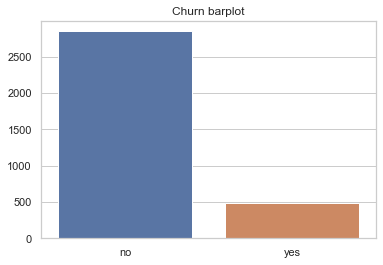

In [132]:
# churn values and proportion
df = df_train_cat.groupBy('churn').count().orderBy('count', ascending=False)
df = df.withColumn('percent', f.col('count')/f.sum('count').over(Window.partitionBy()))
df = df.orderBy('percent', ascending=False)
df = df.toPandas().set_index('churn')
display(df)

# churn variable barplot
sns.set(style="whitegrid") 
sns.barplot(x=['no','yes'], y=df['count'].values).set_title('Churn barplot')

As noticed on table and graph above, churn feature is unbalanced. About 14% of customers stopped using the telecom service and 85% still using it.
#### Categorical variables
##### State

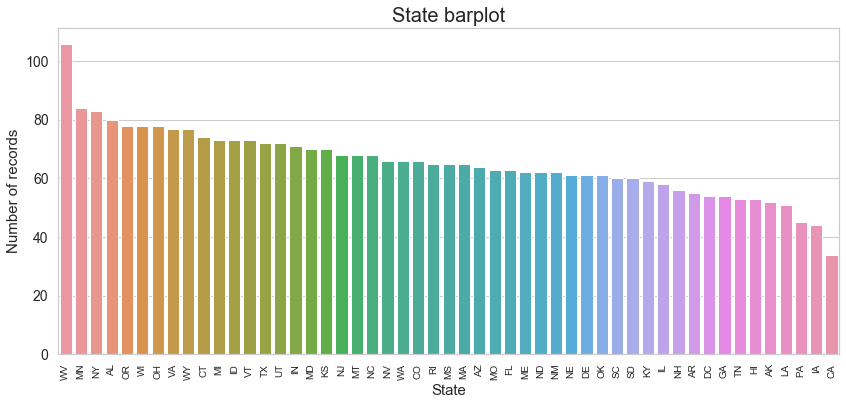

In [231]:
# State values and proportion
df = df_train_cat.groupBy('state').count().orderBy('count', ascending=False)
df = df.toPandas()

# State variable barplot
plt.figure(figsize=(14,6))

sns.barplot(x=df['state'],
            y=df['count'].values)

plt.title('State barplot', size=20)
plt.xlabel('State', size=15)
plt.ylabel('Number of records', size=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.show()

The state with the highest frequency is the West Virginia and the lowest frequency is the California. Other states with a large number of records are New York and Minnesota.
###### Number of records by State shown on the map below:

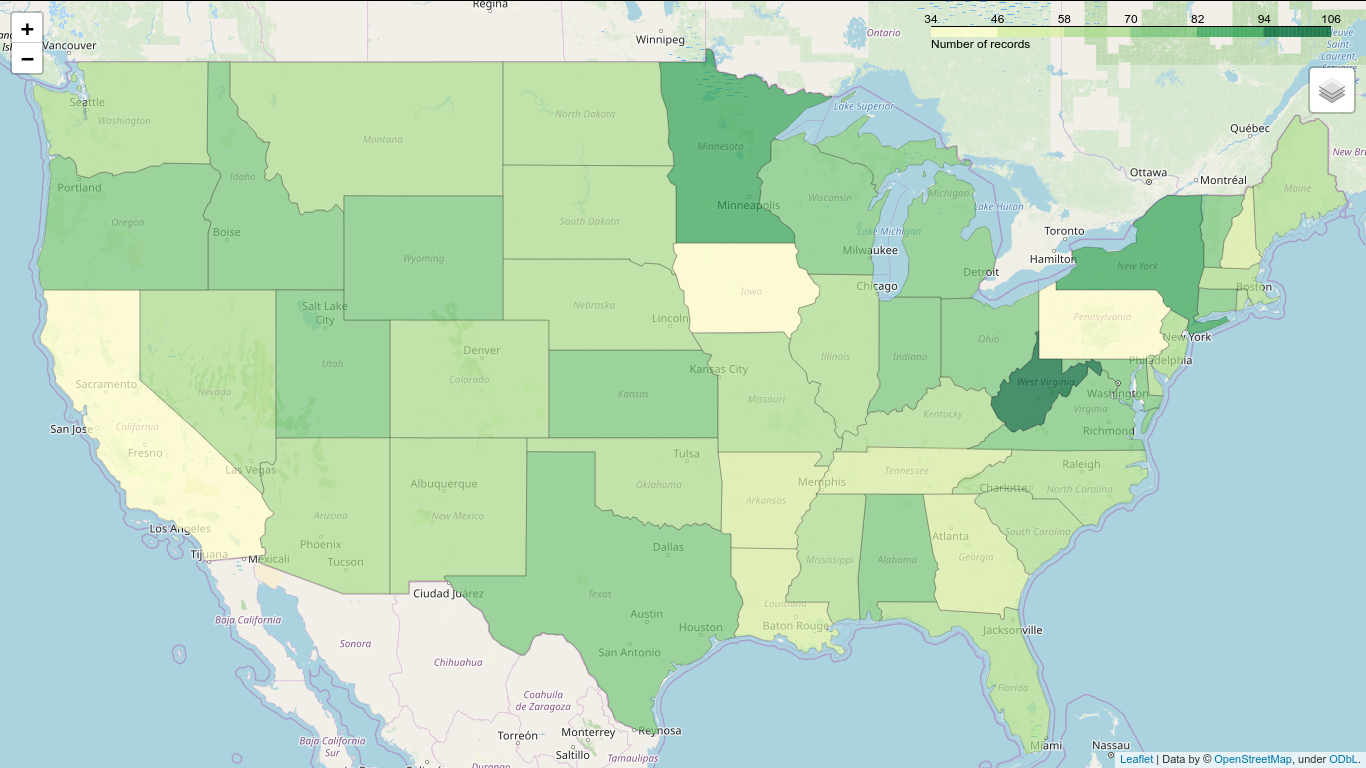

In [142]:
# Map graph
# Load the shape of the zone (US states)
state_geo = os.path.join('', 'us-states.json')
 
# state data
state_data = df_train_cat.groupBy('state').count().orderBy('count', ascending=False).toPandas()
 
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='Number of records by state',
 data=state_data,
 columns=['state', 'count'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of records'
)
folium.LayerControl().add_to(m)
 
# Save to html
m.save('#registers_by_map.html')

display(m)

# Loading map image
# Image(filename='records_by_state.png')

#### Area code

,area_code,count
0,area_code_415,1655
1,area_code_510,840
2,area_code_408,838


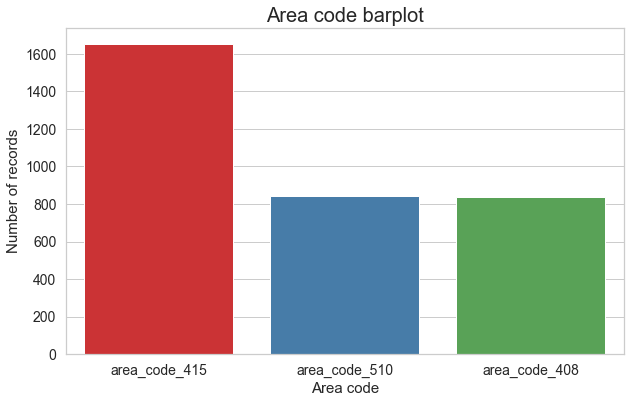

In [241]:
# area_code values and proportion
df = df_train_cat.groupBy('area_code').count().orderBy('count', ascending=False)
df = df.toPandas()
display(df)
 
# area_code variable barplot
plt.figure(figsize=(10,6))
sns.set(style="whitegrid") 
sns.barplot(x=df['area_code'], 
            y=df['count'],
           palette='Set1')

plt.title('Area code barplot', size=20)
plt.xlabel('Area code', size=15)
plt.ylabel('Number of records', size=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

Code area 415 has the largest number of records.
#### International plan

,international_plan,count
0,no,3010
1,yes,323


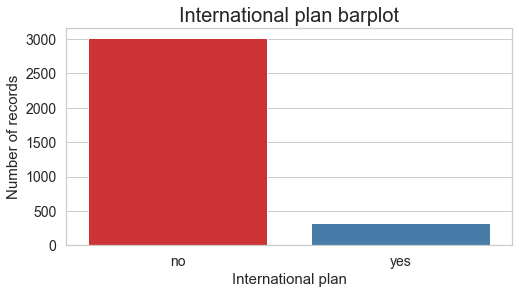

In [242]:
# international_plan values and proportion
df = df_train_cat.groupBy('international_plan').count().orderBy('count', ascending=False)
df = df.toPandas()
display(df)
 
# international_plan variable barplot
plt.figure(figsize=(8,4))
sns.set(style="whitegrid") 
sns.barplot(x=df['international_plan'], 
            y=df['count'],
           palette='Set1')

plt.title('International plan barplot', size=20)
plt.xlabel('International plan', size=15)
plt.ylabel('Number of records', size=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

Most customers do not have international plan.
#### Voice mail plan

,voice_mail_plan,count
0,no,2411
1,yes,922


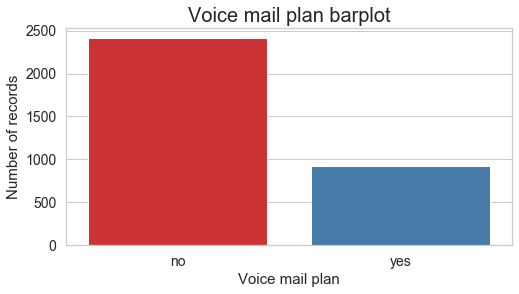

In [243]:
# voice_mail_plan values and proportion
df = df_train_cat.groupBy('voice_mail_plan').count().orderBy('count', ascending=False)
df = df.toPandas()
display(df)
 
# voice_mail_plan variable barplot
plt.figure(figsize=(8,4))
sns.set(style="whitegrid") 
sns.barplot(x=df['voice_mail_plan'], 
            y=df['count'],
           palette='Set1')

plt.title('Voice mail plan barplot', size=20)
plt.xlabel('Voice mail plan', size=15)
plt.ylabel('Number of records', size=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

Most customers do not have voice mail plan.
#### Numerical variables
##### Checking numerical features distributions

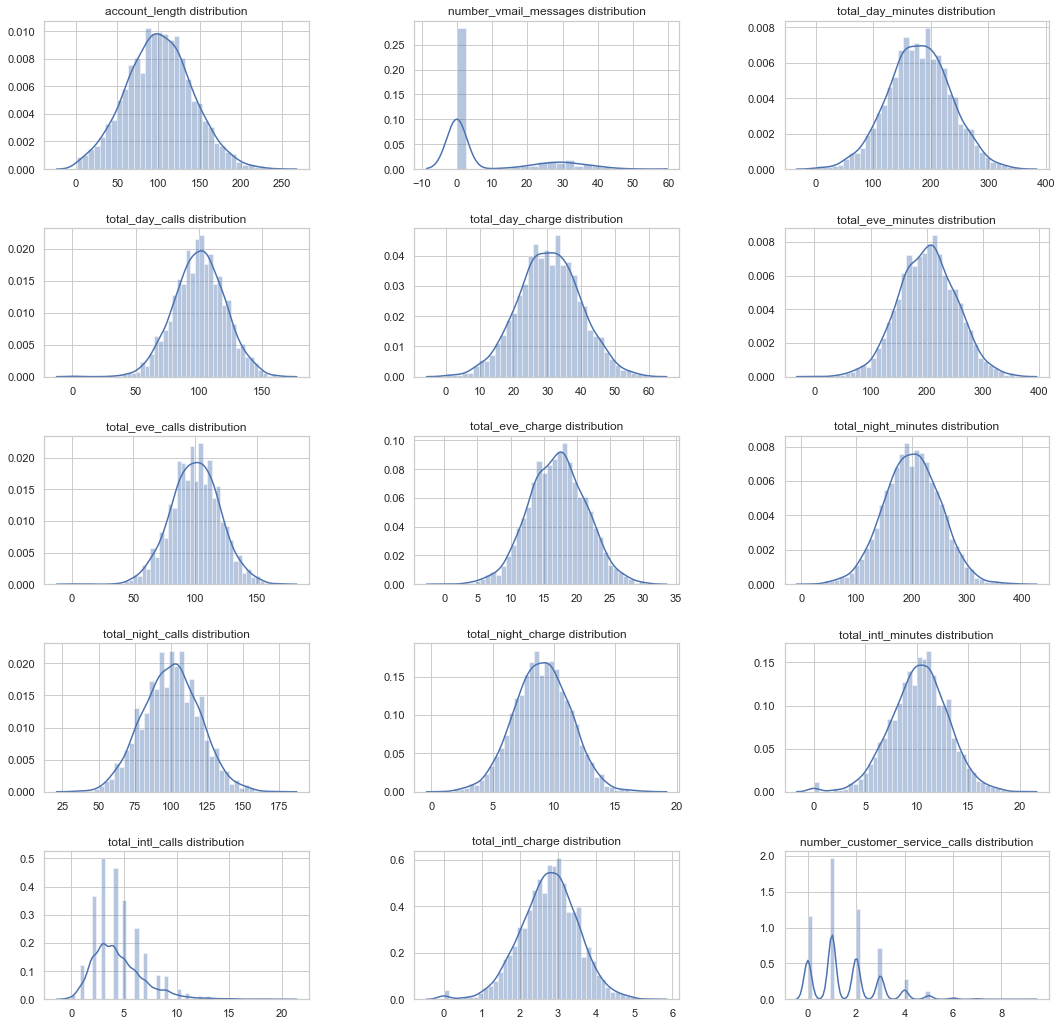

In [310]:
# Features histograms and kde
fig, axs = plt.subplots(ncols=3, nrows=5)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.set_size_inches(18, 18, forward=True)
 
count = 0
 
for i in range(5):
    for j in range(3):
        plt.sca(ax=axs[i][j])
        if count < len(df_train_num.columns):
            col = df_train_num.columns[count]
            y = sc.parallelize(df_train_num.select(col).collect())
            sns.distplot(y.collect()).set_title(col +' distribution')
        else:
            break
             
        count +=1

"account_lenght", " total_day_minutes", " total_day_calls", " total_day_charge", " total_eve_minutes", " total_eve_calls", " total_eve_charge", " total_night_minutes", " total_night_calls", " total_night_charge", " total_intl_minutes", " total_intl_charge" seem to have a normal distribution. "number_vmail_messages" has a bimodal distribution; "total_intl_calls" has a exponential distribution and "number_customer_service_calls" has a multimodal distribution.

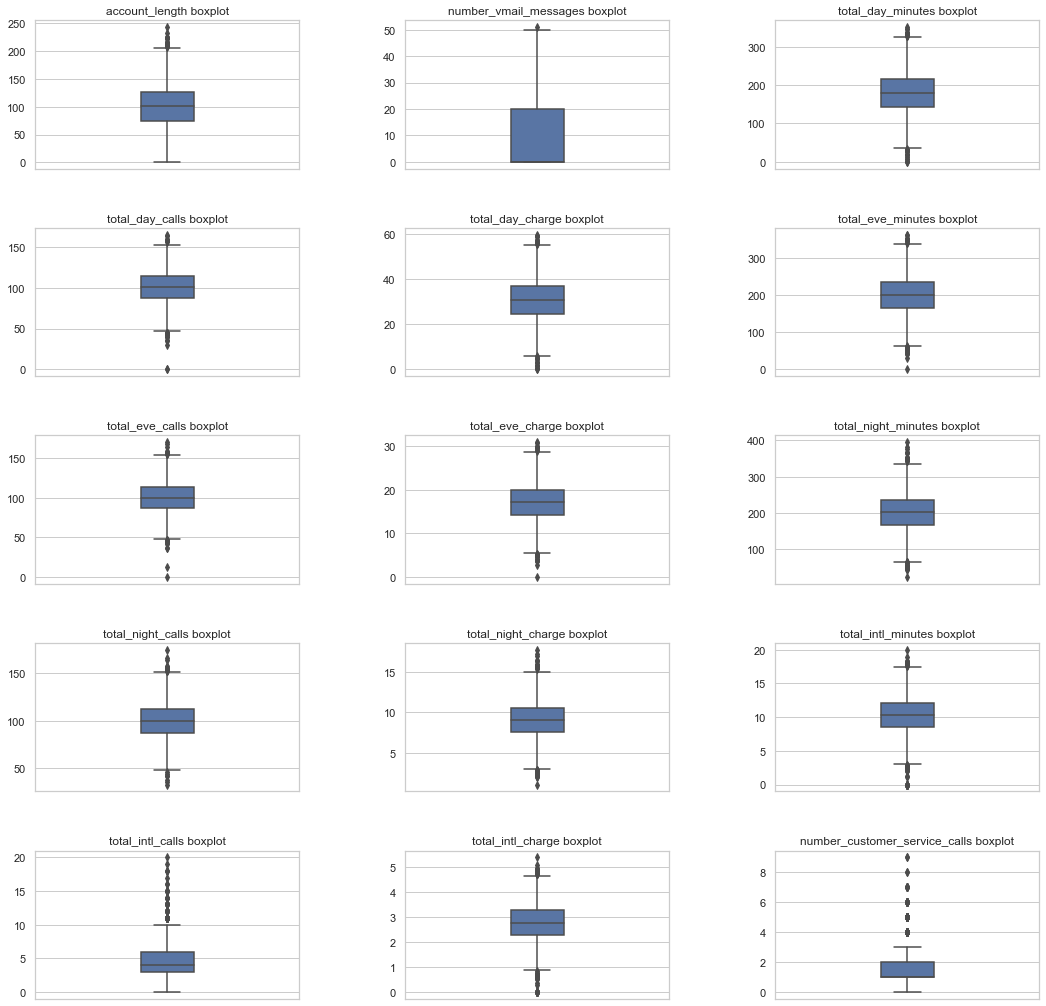

In [125]:
# Features boxplot
fig, axs = plt.subplots(ncols=3, nrows=5)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.set_size_inches(18, 18, forward=True)
 
count = 0
 
for i in range(5):
    for j in range(3):
        plt.sca(ax=axs[i][j])
        if count < len(df_train_num.columns):
            col = df_train_num.columns[count]
            y = sc.parallelize(df_train_num.select(col).collect())
            sns.boxplot(y=y.collect(), width=.20).set_title(col +' boxplot')
        else:
            break
             
        count +=1

"total_intl_calls" and "number_customer_service" have a large number of outliers.
### Bivariate analysis
#### Checking correlation between numerical variables

(-0.5, 16)

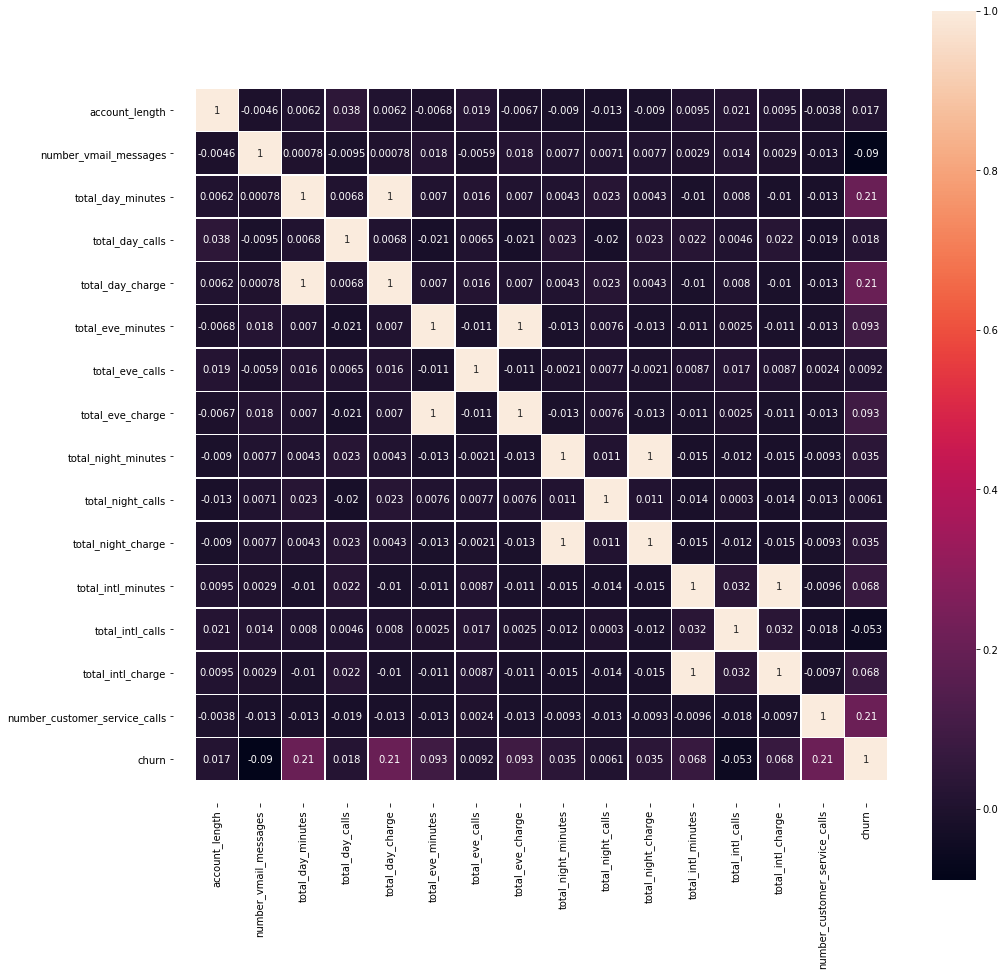

In [65]:
# heat map of correlation values
# Adding churn column and converting to numeric format
cols = df_train_num.columns + ['churn']
df = df_train.select(cols)

df = df.withColumn('churn', f.regexp_replace('churn', 'yes', '1'))
df = df.withColumn('churn', f.regexp_replace('churn', 'no', '0'))

# Converting to numeric
for col_name in df.columns:
    df = df.withColumn(col_name, df[col_name].cast('float'))

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
corrmatrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr = corrmatrix.toArray().tolist()

fig, ax = plt.subplots(figsize=(16,16))

g = sns.heatmap(corr, annot=True, ax=ax, square=True, linewidth=0.5)

plt.yticks(rotation=0)
g.set_xticklabels(df.columns, rotation=90)
g.set_yticklabels(df.columns)
ax.set_ylim([len(corr) + 0.5, 0])
ax.set_xlim([-0.5, len(corr)])

There is a high correlation between the following pairs of variables: "total_day_minutes" and "total_day_charge", "total_night_minutes" and "total_night_charge", "total_eve_minutes" and "total_eve_charge", "total_intl_minutes" and "total_intl_charge".
#### Getting numerical features distribuition grouped by target variable (churn)

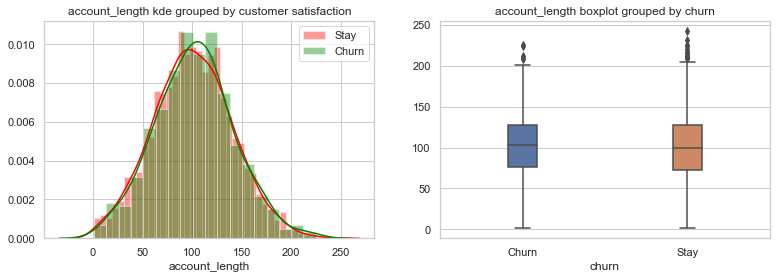

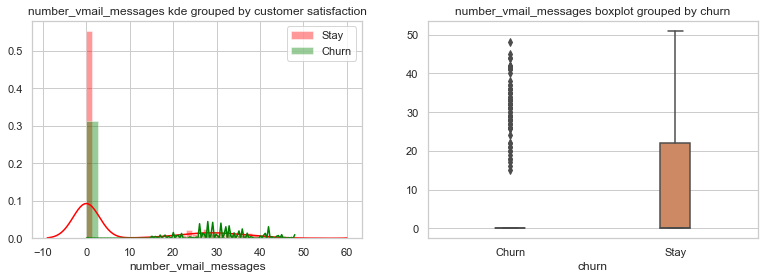

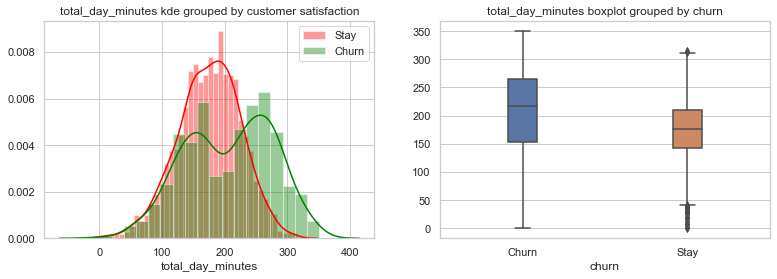

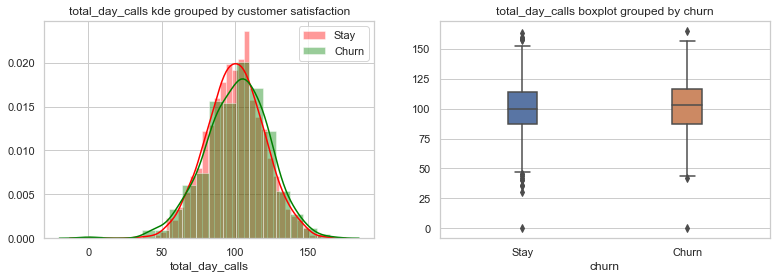

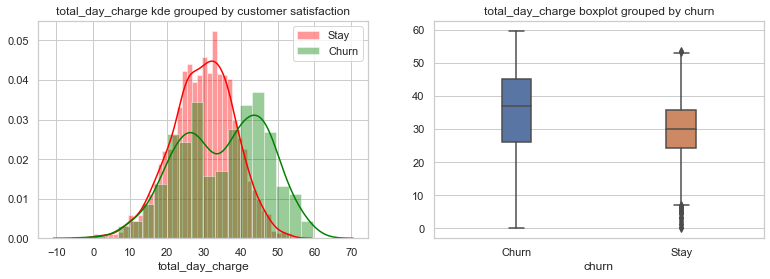

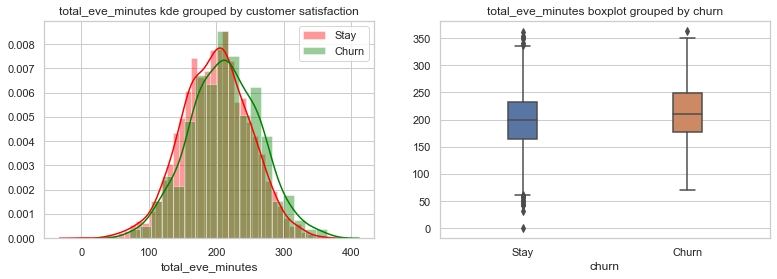

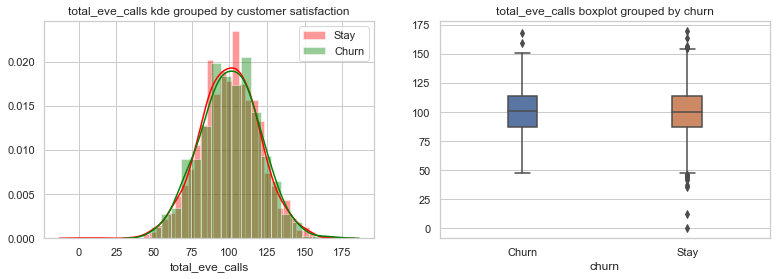

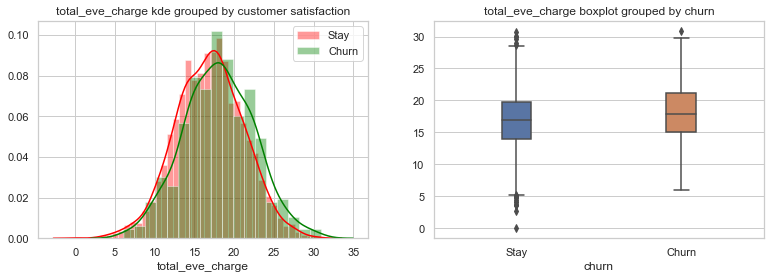

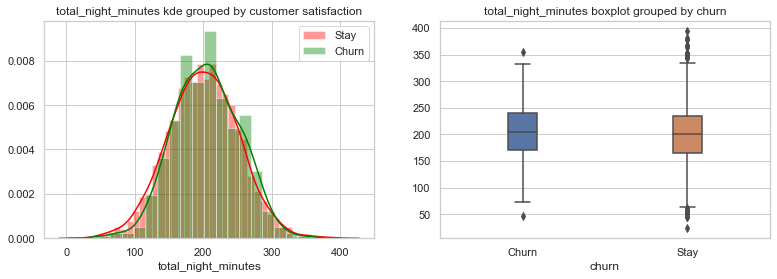

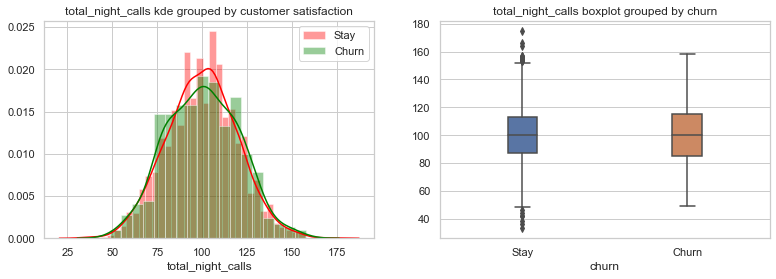

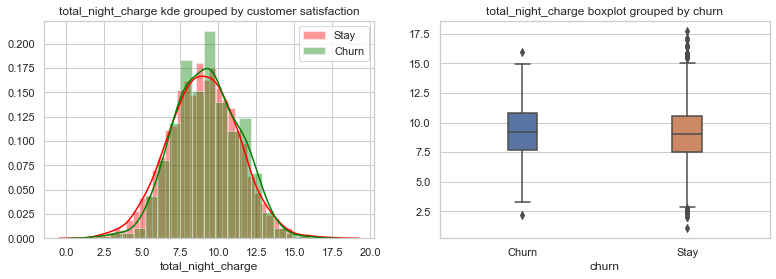

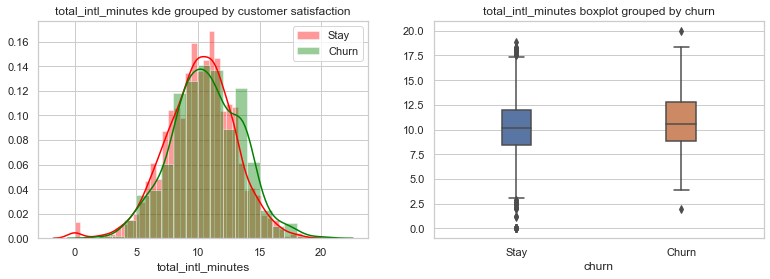

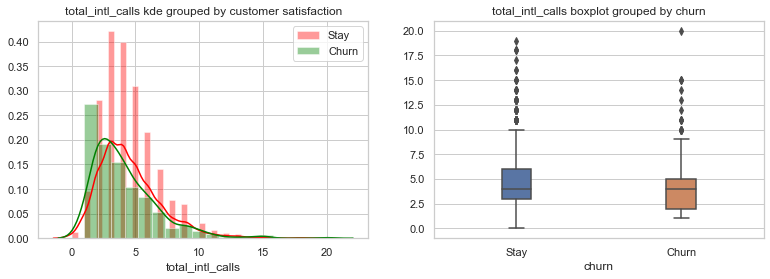

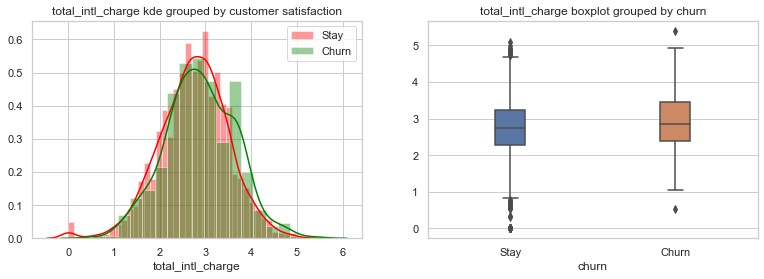

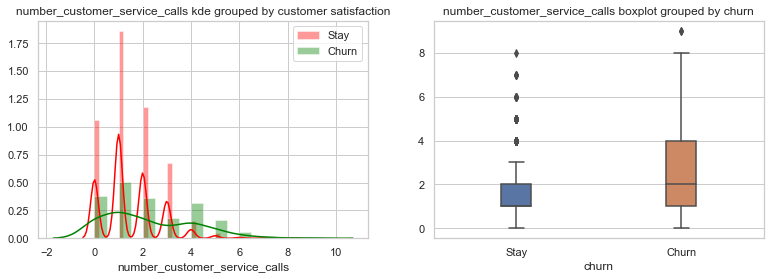

In [117]:
# Getting numerical features distribuition grouped by churn variable
cols = df_train_num.columns + ['churn']
df = df_train.select(cols)

# Converting to numeric
for col_name in df.columns:
    if col_name != 'churn':
        df = df.withColumn(col_name, df[col_name].cast('float'))

for col in df.columns[:-1]:
    y0 = sc.parallelize(df.filter(df.churn == 'no').select(col).collect())
    y1 = sc.parallelize(df.filter(df.churn == 'yes').select(col).collect())

    # Creating dictionary for values grouped by
    my_dict = {'Stay': y0.collect(), 'Churn': y1.collect()}
    
    # sort keys and values together
    sorted_keys, sorted_vals = zip(*sorted(my_dict.items(), key=op.itemgetter(1)))
    
    fig, axs = plt.subplots(ncols=2)
    fig.set_size_inches(13, 4, forward=True)
    sns.distplot(y0.collect(), color='red', label='Stay', ax=axs[0], bins = 40)
    sns.distplot(y1.collect(), color='green', label='Churn', ax=axs[0], bins = 18)
    axs[0].legend()
    axs[0].set_xlabel(col)
    axs[0].set_title(col + ' kde grouped by customer satisfaction')
    sns.boxplot(data=sorted_vals, width=.18, ax=axs[1])
    axs[1].set_xlabel('churn')
    axs[1].set_xticklabels(sorted_keys)
    axs[1].set_title(col + ' boxplot grouped by churn')
    plt.show()

##### Getting categorical features barplot grouped by churn variable

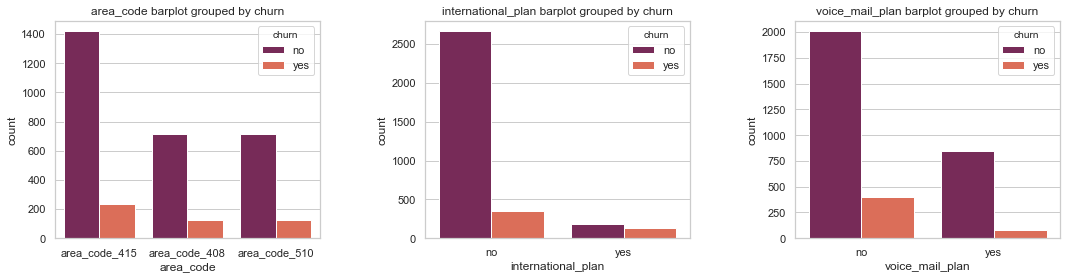

In [131]:
# categorical variables boxplot grouped by churn
cols = df_train_cat.columns
cols.remove('state')
df = df_train.select(cols)

fig, axs = plt.subplots(ncols=3)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.set_size_inches(18, 4, forward=True)

count = 0

for j in range(3):
    plt.sca(ax=axs[j])
    if count < len(df.columns):
        col = df.columns[count]
        df_g = df.groupBy(col, 'churn').count().orderBy('count', ascending=False).toPandas()
        sns.barplot(x=col, y='count', hue="churn", data=df_g, palette="rocket")
        axs[j].set_xlabel(col)
        axs[j].set_title(col + ' barplot grouped by churn')
    else:
        break
    count +=1

##### Churn by state

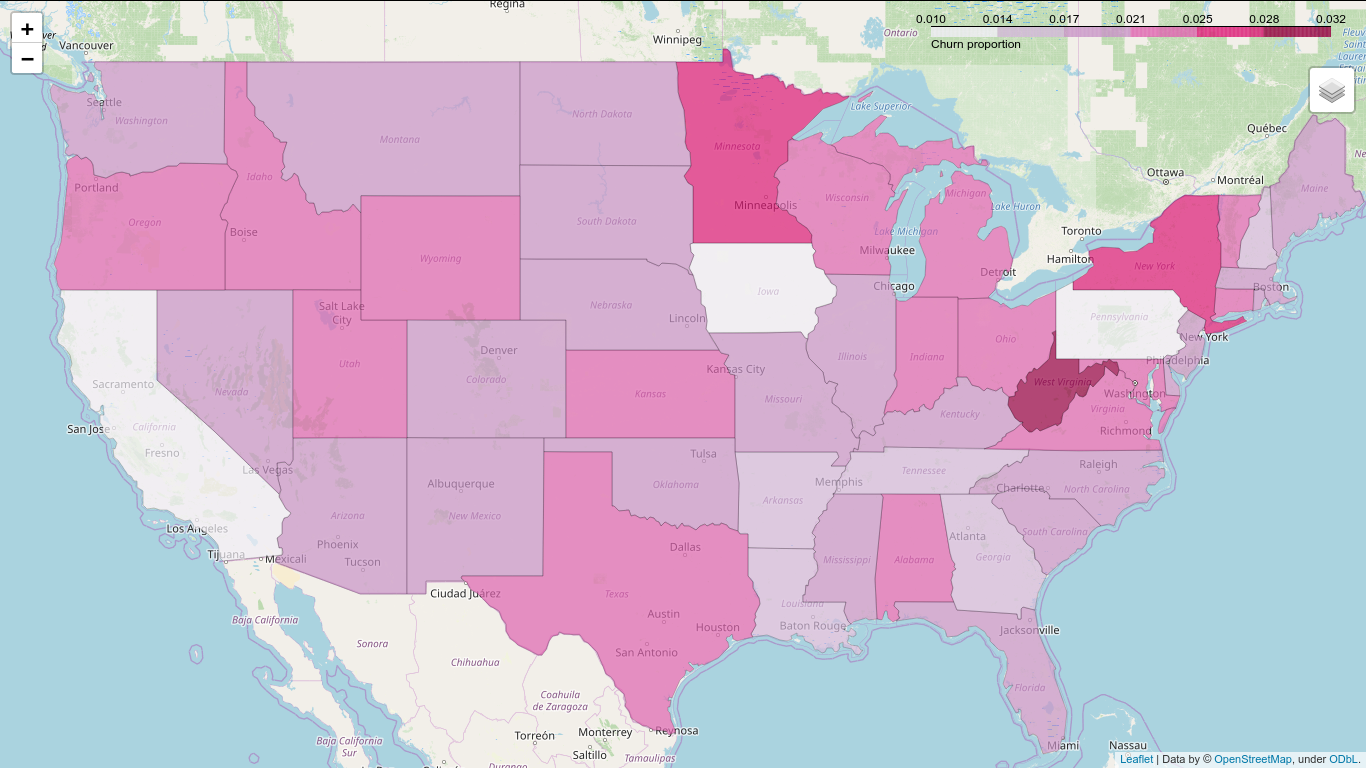

In [140]:
# Map graph exibing churn proportion
# Load the shape of the zone (US states)
state_geo = os.path.join('', 'us-states.json')
 
# state data
# churn values and proportion
state_data = df_train_cat.groupBy('state').count().orderBy('count', ascending=False) \
            .withColumn('percent', f.col('count')/f.sum('count').over(Window.partitionBy())) \
            .orderBy('percent', ascending=False) \
            .toPandas()


# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='Churn proportion by state',
 data=state_data,
 columns=['state', 'percent'],
 key_on='feature.id',
 fill_color='PuRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Churn proportion'
)
folium.LayerControl().add_to(m)
 
# Save to html
m.save('#churn_proportion.html')

display(m)

# # Loading map image
# Image(filename='churn_proportion_by_state.png')

##### Checking categorical features

In [233]:
# Converting categoric features to numeric
df_new_train_cat = df_train_cat

# Converting to binary
for col in ['churn', 'international_plan', 'voice_mail_plan']:
    df_new_train_cat = df_new_train_cat.withColumn(col, f.regexp_replace(col, 'yes', '1'))
    df_new_train_cat = df_new_train_cat.withColumn(col, f.regexp_replace(col, 'no', '0'))


dic_state = {}
count = 1

# Changing state variable
for state in df_new_train_cat.select("state").distinct().collect():
    dic_state[state.state] = str(count)
    count += 1

for item in dic_state.items():
    df_new_train_cat = df_new_train_cat.withColumn('state', f.regexp_replace('state', item[0], item[1]))


# Changing area_code variable
df_new_train_cat = df_new_train_cat.withColumn('area_code', f.regexp_replace(col, 'area_code_408', '1'))
df_new_train_cat = df_new_train_cat.withColumn('area_code', f.regexp_replace(col, 'area_code_510', '2'))
df_new_train_cat = df_new_train_cat.withColumn('area_code', f.regexp_replace(col, 'area_code_415', '3'))

# Converting to numeric
for col_name in df_new_train_cat.columns:
    df_new_train_cat = df_new_train_cat.withColumn(col_name, df_new_train_cat[col_name].cast('float'))

(-0.5, 5)

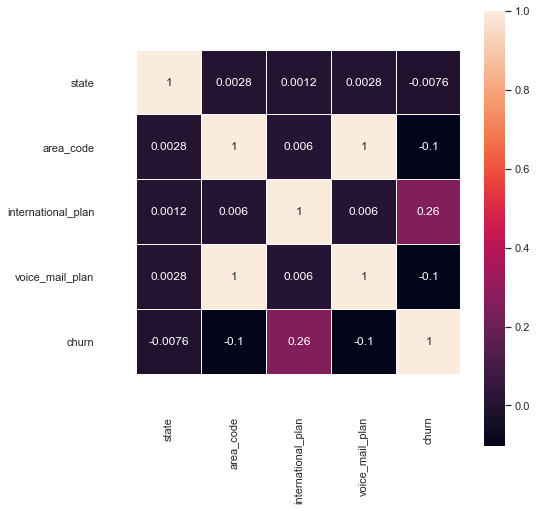

In [236]:
# heat map of correlation values
df = df_new_train_cat

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
corrmatrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr = corrmatrix.toArray().tolist()

fig, ax = plt.subplots(figsize=(8,8))

g = sns.heatmap(corr, annot=True, ax=ax, square=True, linewidth=0.5)

plt.yticks(rotation=0)
g.set_xticklabels(df.columns, rotation=90)
g.set_yticklabels(df.columns)
ax.set_ylim([len(corr) + 0.5, 0])
ax.set_xlim([-0.5, len(corr)])

### Multivariate analysis

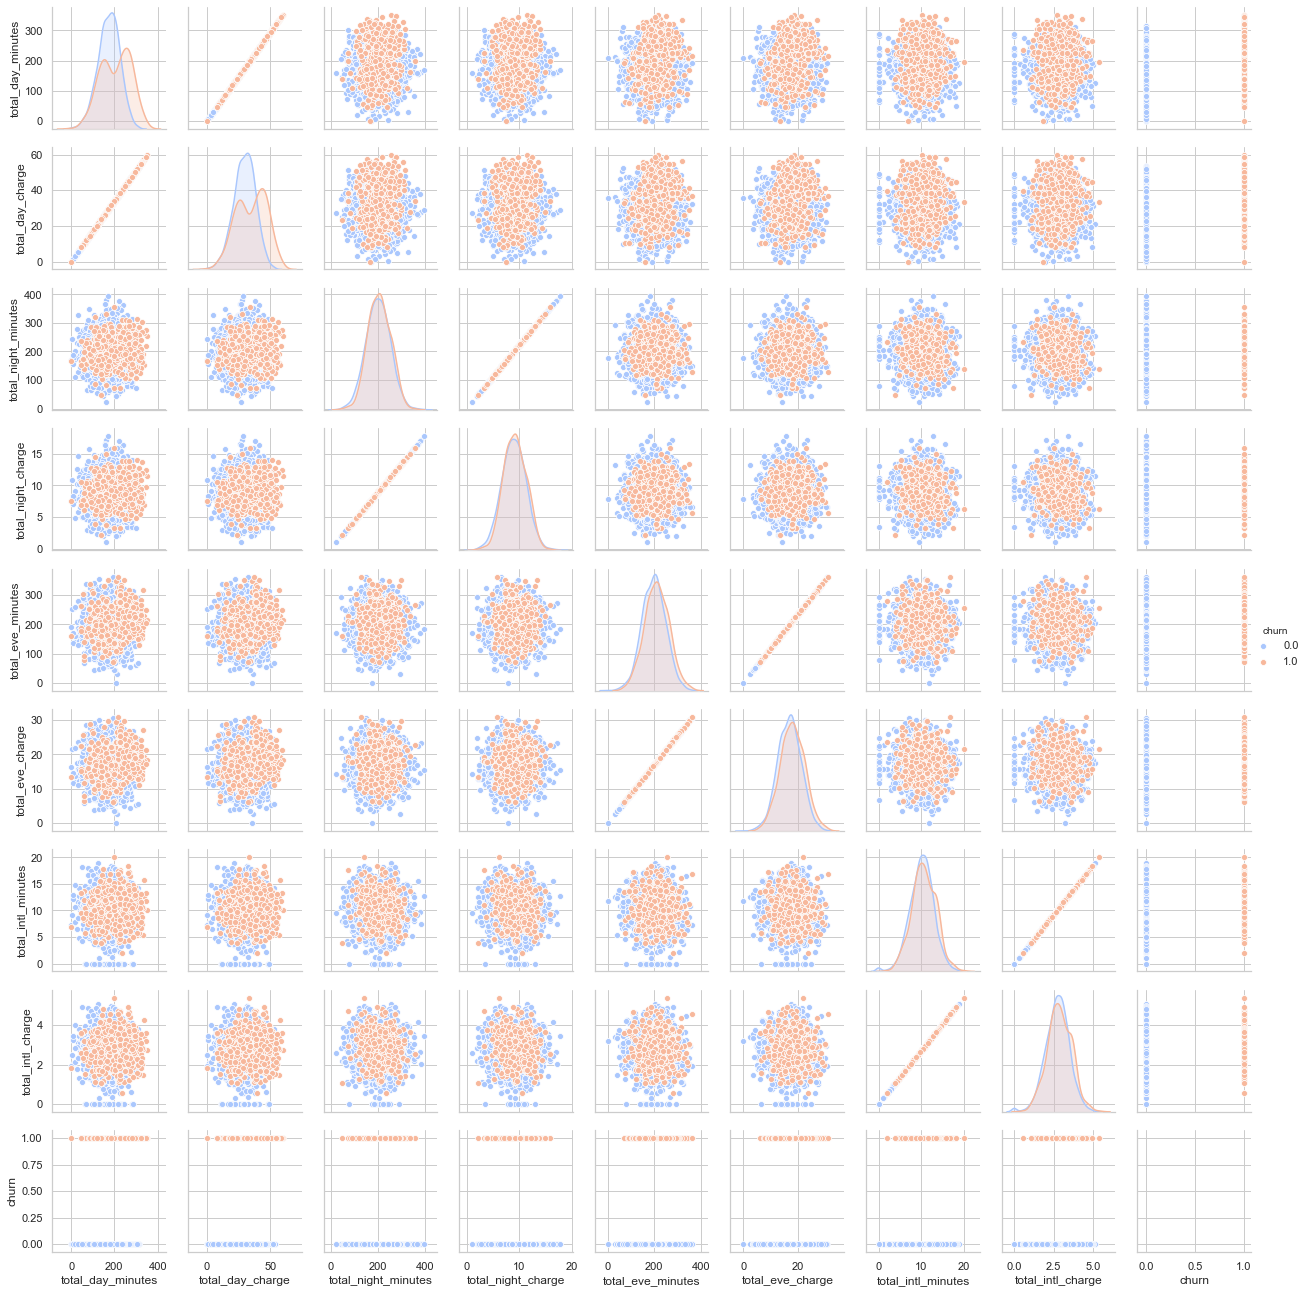

In [201]:
# Adding churn column and converting to numeric format
cols = ["total_day_minutes", "total_day_charge", "total_night_minutes",
        "total_night_charge", "total_eve_minutes", "total_eve_charge",
        "total_intl_minutes", "total_intl_charge", "churn"]

df = df_train.select(cols)

df = df.withColumn('churn', f.regexp_replace('churn', 'yes', '1'))
df = df.withColumn('churn', f.regexp_replace('churn', 'no', '0'))

# Converting to numeric
for col_name in df.columns:
    df = df.withColumn(col_name, df[col_name].cast('float'))

# paiplot
g = sns.pairplot(df.toPandas(), hue='churn', palette='coolwarm')
g.fig.set_size_inches(18,18)

In [230]:
# Checking relation between categorical variables grouped by churn
values = df_train_cat.select('state', 'international_plan', 'voice_mail_plan', 'churn') \
                    .groupBy('international_plan', 'voice_mail_plan', 'churn').count() \
                    .orderBy('count', ascending=False).toPandas()

display(values)

,international_plan,voice_mail_plan,churn,count
0,no,no,no,1878
1,no,yes,no,786
2,no,no,yes,302
3,yes,no,no,130
4,yes,no,yes,101
5,yes,yes,no,56
6,no,yes,yes,44
7,yes,yes,yes,36


In [228]:
values

count
international_plan voice_mail_plan churn       
no                 no              no      1878
                   yes             no       786
                   no              yes      302
yes                no              no       130
                                   yes      101
                   yes             no        56
no                 yes             yes       44
yes                yes             yes       36

## Feature Engineering
### Cleaning sataset
In this session, I converted categorical variables to numeric format, removed high correlated features and unnecessary variable.

In [3]:
# Getting data on rdd format
trainRdd = sc.textFile("data/projeto4_telecom_treino.csv")
testRdd = sc.textFile("data/projeto4_telecom_teste.csv")

In [4]:
# Removing first line of the file (head)
trainRdd2 = trainRdd.filter(lambda x: "state" not in x)
testRdd2 = testRdd.filter(lambda x: "state" not in x)

# Getting clean head
cols = trainRdd.collect()[0].replace("\"",'').split(",")
cols = [col for col in cols if "minute" not in col]
del cols[0]

In [5]:
# Transformação e Limpeza
dic_state = {}
count = 1

# Changing state variable
for state in df_train.select("state").distinct().collect():
    dic_state[state.state] = count
    count += 1

dic_area_code = {'area_code_408': 1,
                'area_code_510': 2,
                'area_code_415': 3}

dic_binary = {"no": 0,
             "yes": 1}

# Removing all minutes variables (highly correlated to charge features)
cols = trainRdd.collect()[0].replace("\"",'').split(",")

removal_index = [i for i in range(len(cols)) if 'minute' in cols[i]]

cols = trainRdd.collect()[0].replace("\"",'').split(",")
cols = [col for col in cols if "minute" not in col]
del cols[0]


# Function to transform and clean rdd data
def cleanRDD(autoStr):
    
    # checking indexing
    if isinstance(autoStr, int):
        return autoStr
    
    # Separate each index with a comma (column separator)
    attList = autoStr.replace("\"",'').split(",")
    
    # Changing and converting categorical variables to numeric
    attList[1] = dic_state[attList[1]]
    attList[3] = dic_area_code[attList[3]]
    attList[4] = dic_binary[attList[4]]
    attList[5] = dic_binary[attList[5]]
    attList[20] = dic_binary[attList[20]]

    # Converting numeric variable to numeric format
    attList[2] = pd.to_numeric(attList[2])
    attList[6:20] = pd.to_numeric(attList[6:20])
        
    # Removing high correlated features and "id" variable
    count = 0

    for i in removal_index:
        del attList[i-count]
        count +=1
        
    del attList[0]
        
    # Creating dictionary for store line values
    line_dict = {}
    
    for i in range(len(cols)):
        line_dict[cols[i]] = attList[i]
        
    print(line_dict)
        
    line = Row(**line_dict)
    
    return line

In [6]:
# Cleaning train and test datasets
cleanTrainRDD = trainRdd2.map(cleanRDD)
cleanTestRDD = testRdd2.map(cleanRDD)

In [9]:
# Converting to a LabeledPoint (target, vector [resources])
def transformVar(row):
    obj = (row["churn"], Vectors.dense([row[col] for col in cols if col != "churn"]))
    return obj

In [12]:
# Use RDD, apply the function, convert to Dataframe and apply the select() function
# train data
cleanTrainRDD2 = cleanTrainRDD.map(transformVar)
train_DF = spSession.createDataFrame(cleanTrainRDD2,["label", "features"])
train_DF.select("label","features").show(10)

# test data
cleanTestRDD2 = cleanTestRDD.map(transformVar)
test_DF = spSession.createDataFrame(cleanTestRDD2,["label", "features"])

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[44.0,128.0,3.0,0...|
|    0|[33.0,107.0,3.0,0...|
|    0|[5.0,137.0,3.0,0....|
|    0|[33.0,84.0,1.0,1....|
|    0|[49.0,75.0,3.0,1....|
|    0|[31.0,118.0,2.0,1...|
|    0|[43.0,121.0,2.0,0...|
|    0|[25.0,147.0,3.0,1...|
|    0|[3.0,117.0,1.0,0....|
|    0|[41.0,141.0,3.0,1...|
+-----+--------------------+
only showing top 10 rows



### Applying MinMaxScaler to data

In [13]:
# Calling MinMaxScaler function
minmax = MinMaxScaler(inputCol="features", outputCol="MinMaxScaledFeatures")

#Train data
# Compute summary statistics by fitting the StandardScaler
minmaxTrainModel = minmax.fit(train_DF)

# Normalize each feature to have unit standard deviation.
minmaxTrain = minmaxTrainModel.transform(train_DF)

#Test data
# Compute summary statistics by fitting the StandardScaler
minmaxTestModel = minmax.fit(test_DF)

# Normalize each feature to have unit standard deviation.
minmaxTest = minmaxTestModel.transform(test_DF)

### Applying StandardScale to data

In [14]:
# Calling StandardScaler function
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Train data
# Compute summary statistics by fitting the StandardScaler
scalerTrainModel = scaler.fit(minmaxTrain)

# Normalize each feature to have unit standard deviation.
scaledTrainData = scalerTrainModel.transform(minmaxTrain)

# Test data
# Compute summary statistics by fitting the StandardScaler
scalerTestModel = scaler.fit(minmaxTest)

# Normalize each feature to have unit standard deviation.
scaledTestData = scalerTestModel.transform(minmaxTest)

## Training models
To predict Customer Churn, I chose to use Logistic Regression to get information on whether customers are going to cancel their plan and their likelihood.
### Logistic Regression

In [16]:
# Binomial model
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit binomial model
lrModel = lr.fit(scaledTrainData.select('label', 'features'))

# Multinomial model
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit multinomial model the model
mlrModel = mlr.fit(scaledTrainData.select('label', 'features'))

# binomial model predictions
binom_predictions = lrModel.transform(scaledTestData.select('label', 'features'))

# multinomial model predictions
multinom_predictions = mlrModel.transform(scaledTestData.select('label', 'features'))

In [17]:
# Evaluating models
# Select (prediction, true label) and compute test error and accuracy

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluating binomial model
bin_accuracy = evaluator.evaluate(binom_predictions)
print("Test Error for binomial model = %g " % (1.0 - bin_accuracy))
print("Accuracy for binomial model = %g " % (bin_accuracy))

# Evaluating multinomial model
mult_accuracy = evaluator.evaluate(multinom_predictions)
print("Test Error for multinomial model = %g " % (1.0 - mult_accuracy))
print("Accuracy for multinomial model = %g " % (mult_accuracy))

Test Error for binomial model = 0.134373 
Accuracy for binomial model = 0.865627 
Test Error for multinomial model = 0.134373 
Accuracy for multinomial model = 0.865627 


## Trying to optimizate model
### Logistic regression optimization
Selecting most important features using PCA algorithm

In [62]:
# Applying pipeline to select features and train model

# Binomial model
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Multinomial model
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Checking model accuracy by varying the number of features
for k in range(3,8):

    # Applying Dimension Reduction with PCA
    bankPCA = PCA(k = k, inputCol = "features", outputCol = "pcaFeatures")
    
    # Applying pipeline to select features and train model
    binom_pipeline = Pipeline(stages=[bankPCA, lr])
    multinom_pipeline = Pipeline(stages=[bankPCA, mlr])

    # Fit the pipeline to training documents.
    binom_model = binom_pipeline.fit(scaledTrainData)
    multinom_model = multinom_pipeline.fit(scaledTrainData)

    # Make predictions on test documents.
    binom_predictions = binom_model.transform(scaledTestData)
    multinom_predictions = multinom_model.transform(scaledTestData)

    bin_accuracy = evaluator.evaluate(binom_predictions)
    print("Accuracy for binomial model for %g features = %g " % (k, bin_accuracy))

    # Evaluating multinomial model
    mult_accuracy = evaluator.evaluate(multinom_predictions)
    print("Accuracy for multinomial model for %g features = %g " % (k, mult_accuracy))

Accuracy for binomial model for 3 features = 0.865627 
Accuracy for multinomial model for 3 features = 0.865627 
Accuracy for binomial model for 4 features = 0.865627 
Accuracy for multinomial model for 4 features = 0.865627 
Accuracy for binomial model for 5 features = 0.865627 
Accuracy for multinomial model for 5 features = 0.865627 
Accuracy for binomial model for 6 features = 0.865627 
Accuracy for multinomial model for 6 features = 0.865627 
Accuracy for binomial model for 7 features = 0.865627 
Accuracy for multinomial model for 7 features = 0.865627 


Decreasing the number of variables did not change the model's performance.
###### Using standard deviation dataset

In [66]:
# binomial model
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

sd_train = scaledTrainData.select('label', 'scaledFeatures').withColumnRenamed("scaledFeatures","features")
sd_test = scaledTrainData.select('label', 'scaledFeatures').withColumnRenamed("scaledFeatures","features")

# training model
sd_model = lr.fit(sd_train)

# Predction
sd_prediction = sd_model.transform(sd_test)

sd_accuracy = evaluator.evaluate(sd_prediction)
print("Accuracy for binomial model for standard scaled data = %g " % (sd_accuracy))

Accuracy for binomial model for standard scaled data = 0.855086 


###### Using min-max scaled deviation dataset

In [72]:
# binomial model
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

minmax_train = scaledTrainData.select('label', 'MinMaxScaledFeatures') \
    .withColumnRenamed("MinMaxScaledFeatures","features")

minmax_test = scaledTrainData.select('label', 'MinMaxScaledFeatures') \
    .withColumnRenamed("MinMaxScaledFeatures","features")

# training model
minmax_model = lr.fit(minmax_train)

# Predction
minmax_prediction = minmax_model.transform(minmax_test)

minmax_accuracy = evaluator.evaluate(minmax_prediction)
print("Accuracy for binomial model for standard scaled data = %g " % (minmax_accuracy))

Accuracy for binomial model for standard scaled data = 0.855086 


In [74]:
k = 7

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Applying Dimension Reduction with PCA
bankPCA = PCA(k = k, inputCol = "features", outputCol = "pcaFeatures")

# Applying pipeline to select features and train model
binom_pipeline = Pipeline(stages=[bankPCA, lr])
multinom_pipeline = Pipeline(stages=[bankPCA, mlr])

# Fit the pipeline to training documents.
binom_model = binom_pipeline.fit(sd_train)
multinom_model = multinom_pipeline.fit(sd_train)

# Make predictions on test documents.
binom_predictions = binom_model.transform(sd_test)
multinom_predictions = multinom_model.transform(sd_test)

bin_accuracy = evaluator.evaluate(binom_predictions)
print("Accuracy for binomial model for %g features = %g " % (k, bin_accuracy))

# Evaluating multinomial model
mult_accuracy = evaluator.evaluate(multinom_predictions)
print("Accuracy for multinomial model for %g features = %g " % (k, mult_accuracy))

Accuracy for binomial model for 7 features = 0.855086 
Accuracy for multinomial model for 7 features = 0.855086 


In [106]:
# Converting to a LabeledPoint (target, vector [resources])
cols = trainRdd.collect()[0].replace("\"",'').split(",")
cols = trainRdd.collect()[0].replace("\"",'').split(",")
cols = [col for col in cols if "minute" not in col]
del cols[0]

drop_cols = ['churn', 'international_plan', 'voice_mail_plan']

def labeledPoint(row):
    obj = (row["churn"], row["international_plan"], \
           row["voice_mail_plan"], Vectors.dense([row[col] for col in cols if col not in drop_cols]))
    return obj

In [112]:
cleanTrainRDD3 = cleanTrainRDD.map(labeledPoint)
train_DF2 = spSession.createDataFrame(cleanTrainRDD3,["label", 'international_plan', \
                                                      'voice_mail_plan', "features"])
train_DF2.show(10)

# test data
cleanTestRDD3 = cleanTestRDD.map(labeledPoint)
test_DF2 = spSession.createDataFrame(cleanTestRDD3,["label", 'international_plan', \
                                                    'voice_mail_plan', "features"])

+-----+------------------+---------------+--------------------+
|label|international_plan|voice_mail_plan|            features|
+-----+------------------+---------------+--------------------+
|    0|                 0|              1|[44.0,128.0,3.0,2...|
|    0|                 0|              1|[33.0,107.0,3.0,2...|
|    0|                 0|              0|[5.0,137.0,3.0,0....|
|    0|                 1|              0|[33.0,84.0,1.0,0....|
|    0|                 1|              0|[49.0,75.0,3.0,0....|
|    0|                 1|              0|[31.0,118.0,2.0,0...|
|    0|                 0|              1|[43.0,121.0,2.0,2...|
|    0|                 1|              0|[25.0,147.0,3.0,0...|
|    0|                 0|              0|[3.0,117.0,1.0,0....|
|    0|                 1|              1|[41.0,141.0,3.0,3...|
+-----+------------------+---------------+--------------------+
only showing top 10 rows



In [109]:
cleanTrainRDD3.collect()[0]

(0,
 0,
 1,
 DenseVector([44.0, 128.0, 3.0, 25.0, 110.0, 45.07, 99.0, 16.78, 91.0, 11.01, 3.0, 2.7, 1.0]))

In [107]:
cols

['state',
 'account_length',
 'area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_calls',
 'total_day_charge',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_calls',
 'total_night_charge',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'churn']